In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

# Configuración de parámetros
img_size = (224, 224)  # Tamaño estándar de entrada para VGG16
batch_size = 32
num_classes = 3  # Ajusta esto según el número de clases en tu conjunto de datos
epochs = 50
learning_rate = 1e-5

# Cargar el modelo VGG16 preentrenado sin la capa de clasificación final
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Congelar las capas base para evitar que se actualicen durante el entrenamiento
for layer in base_model.layers:
    layer.trainable = False

# Añadir capas personalizadas para clasificación
x = Flatten()(base_model.output)  # Aplanar las salidas del modelo base
x = Dense(512, activation='relu')(x)  # Capa densa con activación ReLU
x = Dropout(0.5)(x)  # Dropout para reducir el sobreajuste
x = Dense(num_classes, activation='softmax')(x)  # Capa de salida con activación softmax

# Crear el modelo completo
model = Model(inputs=base_model.input, outputs=x)

# Compilar el modelo
model.compile(optimizer=Adam(learning_rate=learning_rate), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# Configuración del generador de datos
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1.0/255)

train_dir = 'C:/Users/yeiko/Capstone/Dataset/train'  # Ruta de entrenamiento
val_dir = 'C:/Users/yeiko/Capstone/Dataset/valid'  # Ruta de validación

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

# Entrenar el modelo
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // batch_size,
    epochs=epochs
)

# Guardar el modelo reentrenado
model.save('C:/Users/yeiko/Capstone/Modelos/modelo_vgg16_trained.h5')


In [8]:
from tensorflow.keras.models import load_model

# Usa la ruta completa para cargar el modelo
model = load_model('D:/UPN/modelo_vgg16_v9.h5')


Found 141 images belonging to 3 classes.


C:\Users\yeiko\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


5/5 ━━━━━━━━━━━━━━━━━━━━ 15s 3s/step - accuracy: 0.9422 - loss: 0.1576
Precisión en el conjunto de prueba: 0.95
Pérdida en el conjunto de prueba: 0.15
5/5 ━━━━━━━━━━━━━━━━━━━━ 18s 4s/step


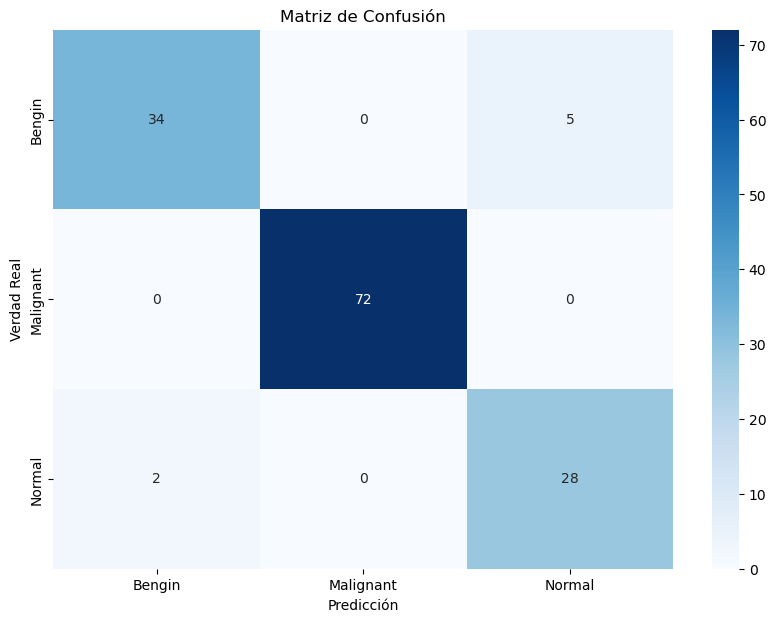


Reporte de clasificación:
              precision    recall  f1-score   support

      Bengin       0.94      0.87      0.91        39
   Malignant       1.00      1.00      1.00        72
      Normal       0.85      0.93      0.89        30

    accuracy                           0.95       141
   macro avg       0.93      0.94      0.93       141
weighted avg       0.95      0.95      0.95       141



In [10]:
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Configuración de parámetros
img_size = (224, 224)  # Tamaño de imagen esperado por el modelo
batch_size = 32

# Crear el generador de datos para el conjunto de prueba
test_datagen = ImageDataGenerator(rescale=1.0/255)
test_dir = 'C:/Users/yeiko/Capstone/Dataset/test'  # Cambia esta ruta según la ubicación de tus datos de prueba

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # Importante para obtener predicciones en el mismo orden que las etiquetas
)

# Recompliar el modelo (opcional, si ves la advertencia)
model.compile(optimizer=Adam(learning_rate=0.0001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# Evaluar el modelo en el conjunto de prueba
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Precisión en el conjunto de prueba: {test_accuracy:.2f}")
print(f"Pérdida en el conjunto de prueba: {test_loss:.2f}")

# Obtener las predicciones del modelo
predictions = model.predict(test_generator)

# Convertir las predicciones a etiquetas (con una clase por cada predicción)
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes

# Generar la matriz de confusión
cm = confusion_matrix(y_true, y_pred)

# Visualizar la matriz de confusión con un heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicción')
plt.ylabel('Verdad Real')
plt.title('Matriz de Confusión')
plt.show()

# Reporte de clasificación (Precision, Recall, F1-Score)
report = classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys())
print("\nReporte de clasificación:")
print(report)


In [5]:
from tensorflow.keras.optimizers import Adam

# Recomendaría recompilar el modelo para asegurarse de que tenga las métricas configuradas
model.compile(optimizer=Adam(learning_rate=0.0001),  # Ajusta la tasa de aprendizaje si es necesario
              loss='categorical_crossentropy',       # Asegúrate de usar la función de pérdida adecuada
              metrics=['accuracy'])                  # Configura las métricas que deseas

# Luego puedes evaluar o predecir
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Precisión en el conjunto de prueba: {test_accuracy:.2f}")
print(f"Pérdida en el conjunto de prueba: {test_loss:.2f}")


4/4 ━━━━━━━━━━━━━━━━━━━━ 12s 3s/step - accuracy: 0.8354 - loss: 0.3668
Precisión en el conjunto de prueba: 0.90
Pérdida en el conjunto de prueba: 0.24


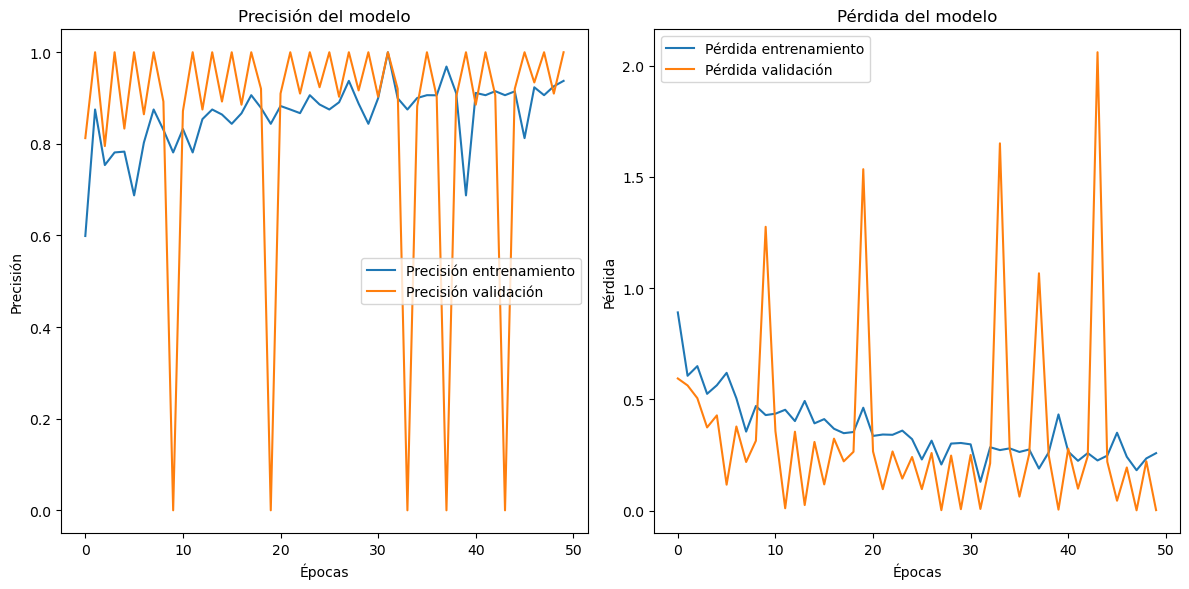

In [11]:
import matplotlib.pyplot as plt

# Suponiendo que `history` es el historial del entrenamiento del modelo
# Si ya tienes el historial, puedes cargarlo directamente o usar la variable `history`
# Ejemplo: history = model.fit(...)

# Graficar precisión
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)  # Subgráfico para la precisión
plt.plot(history.history['accuracy'], label='Precisión entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión validación')
plt.title('Precisión del modelo')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

# Graficar pérdida
plt.subplot(1, 2, 2)  # Subgráfico para la pérdida
plt.plot(history.history['loss'], label='Pérdida entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida validación')
plt.title('Pérdida del modelo')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

# Mostrar los gráficos
plt.tight_layout()
plt.show()


In [3]:
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

# Cargar el modelo original
model_path = 'C:/Users/yeiko/Capstone/Modelos/modelo_vgg16_v8.h5'
model = load_model(model_path)

# Número de clases actualizado
num_classes = 3 # Cambia esto según el número de clases en tu conjunto de datos

# Reconstruir el modelo sin la última capa
x = model.layers[-2].output  # Salida de la penúltima capa
output = Dense(num_classes, activation='softmax')(x)  # Nueva capa de salida

# Crear el nuevo modelo
model = Model(inputs=model.input, outputs=output)

# Compilar el modelo
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Configuración del generador de datos
img_size = (224, 224)
batch_size = 32

# Generadores de datos para entrenamiento y validación
train_datagen = ImageDataGenerator(rescale=1.0/255, rotation_range=20, width_shift_range=0.2,
                                   height_shift_range=0.2, shear_range=0.2, zoom_range=0.2,
                                   horizontal_flip=True, fill_mode='nearest')

val_datagen = ImageDataGenerator(rescale=1.0/255)

train_dir = 'C:/Users/yeiko/Capstone/Dataset/train'  # Cambia esta ruta según tus datos de entrenamiento
val_dir = 'C:/Users/yeiko/Capstone/Dataset/valid'      # Cambia esta ruta según tus datos de validación

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

# Reentrenar el modelo
epochs = 50  # Cambia el número de épocas según tus necesidades
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // batch_size,
    epochs=epochs
)

# Guardar el modelo reentrenado
model.save('C:/Users/yeiko/Capstone/Modelos/modelo_vgg16_v9.h5')


Found 2724 images belonging to 3 classes.
Found 289 images belonging to 3 classes.
Epoch 1/50


C:\Users\yeiko\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


85/85 ━━━━━━━━━━━━━━━━━━━━ 295s 3s/step - accuracy: 0.5116 - loss: 1.0308 - val_accuracy: 0.8125 - val_loss: 0.5936
Epoch 2/50
 1/85 ━━━━━━━━━━━━━━━━━━━━ 4:43 3s/step - accuracy: 0.8750 - loss: 0.6057

C:\Users\yeiko\anaconda3\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


85/85 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.8750 - loss: 0.6057 - val_accuracy: 1.0000 - val_loss: 0.5623
Epoch 3/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 339s 4s/step - accuracy: 0.7485 - loss: 0.6846 - val_accuracy: 0.7951 - val_loss: 0.5051
Epoch 4/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7812 - loss: 0.5246 - val_accuracy: 1.0000 - val_loss: 0.3736
Epoch 5/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 292s 3s/step - accuracy: 0.7808 - loss: 0.5761 - val_accuracy: 0.8333 - val_loss: 0.4278
Epoch 6/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6875 - loss: 0.6189 - val_accuracy: 1.0000 - val_loss: 0.1164
Epoch 7/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 298s 3s/step - accuracy: 0.8056 - loss: 0.5041 - val_accuracy: 0.8646 - val_loss: 0.3779
Epoch 8/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8750 - loss: 0.3549 - val_accuracy: 1.0000 - val_loss: 0.2184
Epoch 9/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 293s 3s/step - accuracy: 0.8367 - loss: 0.4617 - val_accuracy: 0.8924 - val_loss: 0.3139

RuntimeError: Can't decrement id ref count (unable to extend file properly)

In [5]:
model.save('D:/UPN/modelo_vgg16_v9.h5')


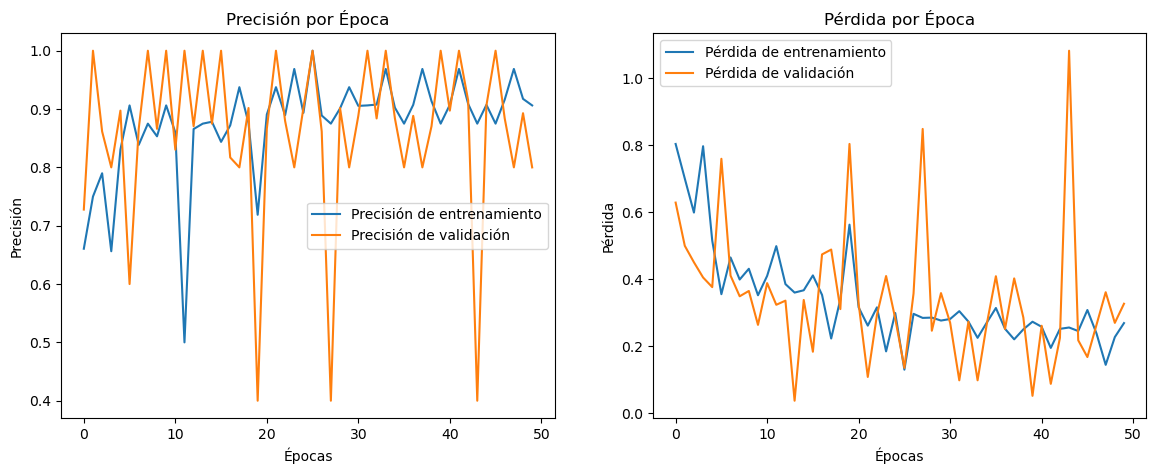

4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step - accuracy: 0.8896 - loss: 0.2510
Precisión en el conjunto de prueba: 0.93
Pérdida en el conjunto de prueba: 0.19
4/4 ━━━━━━━━━━━━━━━━━━━━ 12s 3s/step
Reporte de Clasificación:
              precision    recall  f1-score   support

      Bengin       0.88      0.58      0.70        12
   Malignant       1.00      0.97      0.99        72
      Normal       0.81      0.97      0.88        30

    accuracy                           0.93       114
   macro avg       0.89      0.84      0.85       114
weighted avg       0.94      0.93      0.93       114



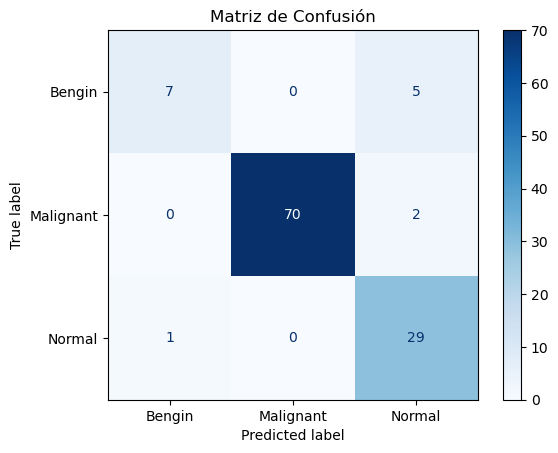

In [9]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Graficar precisión y pérdida para entrenamiento y validación
def plot_accuracy_and_loss(history):
    # Precisión
    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Precisión de entrenamiento')
    plt.plot(history.history['val_accuracy'], label='Precisión de validación')
    plt.title('Precisión por Época')
    plt.xlabel('Épocas')
    plt.ylabel('Precisión')
    plt.legend()

    # Pérdida
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Pérdida de entrenamiento')
    plt.plot(history.history['val_loss'], label='Pérdida de validación')
    plt.title('Pérdida por Época')
    plt.xlabel('Épocas')
    plt.ylabel('Pérdida')
    plt.legend()
    
    plt.show()

# Llamar a la función para graficar precisión y pérdida
plot_accuracy_and_loss(history)

# Evaluar el modelo en el conjunto de prueba
# Esto asume que tienes un generador de prueba configurado
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Precisión en el conjunto de prueba: {test_accuracy:.2f}")
print(f"Pérdida en el conjunto de prueba: {test_loss:.2f}")

# Obtener predicciones
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convertir las probabilidades en clases
y_true = test_generator.classes  # Clases reales

# Generar y mostrar el reporte de clasificación
print("Reporte de Clasificación:")
print(classification_report(y_true, y_pred_classes, target_names=test_generator.class_indices.keys()))

# Matriz de confusión
cm = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_generator.class_indices.keys())
disp.plot(cmap=plt.cm.Blues)
plt.title('Matriz de Confusión')
plt.show()
